# Anomaly detection using the Iris dataset

The Iris dataset is not perhaps the most natural dataset for anomaly detection, so I will get round to writing one with a slightly more appropriate dataset at some point. 

Regardless, the principles are the same; unsupervised learning of a 'normal' model, e.g. generating a model of normality and using that to identify anomalous data points. It's then possible to use the Log Likelihood score to identify points that aren't 'normal'. 

In practical terms there are some hurdles, in that ideally the model of normality should be (in general) normal, and abnormal points in the system that you're monitoring should be removed (it really is quite sensitive to training data); whether manually or automatically. If performing automatic removal you can use a more constrained model rather than using exactly the same structure. On the other hand, there are a host of benefits; it's possible to identify the likely variables that caused the abnormality, and it's also possible to identify what the model is expecting it to be. In that regard (unlike many other approaches), the model can essenentially be debugged by identifying which variables are not performing in the way that would be expected. This article won't cover those two additional points, but I will return to it at a later date.

First off, define all the imports.

In [6]:
%matplotlib notebook
import pandas as pd
import sys
sys.path.append("../../../bayesianpy")

import bayesianpy
from bayesianpy.network import Builder as builder

import logging
import os

import matplotlib.pyplot as plt
from IPython.display import display

In [7]:
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

bayesianpy.jni.attach(logger)

db_folder = bayesianpy.utils.get_path_to_parent_dir("")
iris = pd.read_csv(os.path.join(db_folder, "data/iris.csv"), index_col=False)

Rather than using a template to build the network, it's fairly easy to define it by hand. The network looks something like the following:

<IPython.core.display.Javascript object>


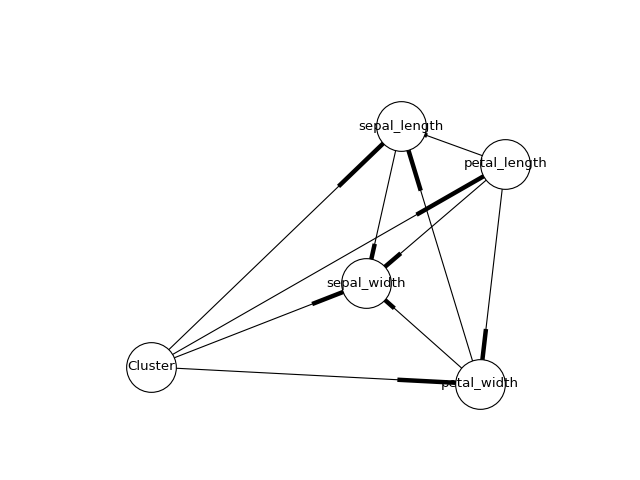

In [8]:
network = bayesianpy.network.create_network()
cluster = builder.create_cluster_variable(network, 4)
petal_length = builder.create_continuous_variable(network, "petal_length")
petal_width = builder.create_continuous_variable(network, "petal_width")
sepal_length = builder.create_continuous_variable(network, "sepal_length")
sepal_width = builder.create_continuous_variable(network, "sepal_width")
nodes = [petal_length, petal_width, sepal_length, sepal_width]

for i, node in enumerate(nodes):
    builder.create_link(network, cluster, node)
    for j in range(i+1, len(nodes)):
        builder.create_link(network, node, nodes[j])

layout = bayesianpy.visual.NetworkLayout(network)
graph = layout.build_graph()
pos = layout.fruchterman_reingold_layout(graph)
layout.visualise(graph, pos)

Using the above network, train the model on only two of the classes (for clarity, I chose the two that are least separated, versicolor and virginica)

In [9]:
# build the 'normal' model on two of the classes
model = bayesianpy.model.NetworkModel(network, logger)

with bayesianpy.data.DataSet(iris.drop('iris_class', axis=1), db_folder, logger) as dataset:

    subset = dataset.subset(
        iris[(iris.iris_class == "Iris-versicolor") | (iris.iris_class == "Iris-virginica")].index.tolist())

    model.train(subset)

INFO:root:Writing 150 rows to storage
Writing 150 rows to storage
Writing 150 rows to storage
INFO:root:Finished writing 150 rows to storage
Finished writing 150 rows to storage
Finished writing 150 rows to storage
INFO:root:Training model...
Training model...
Training model...
INFO:root:Finished training model
Finished training model
Finished training model


The network is then ready for anomaly detection; this entails applying the entire dataset to the trained model, and plotting the results. The Log Likelihood will always give a negative value, the closer to 0, the more normal the applied data sample is.

In [10]:
with bayesianpy.data.DataSet(iris.drop('iris_class', axis=1), db_folder, logger) as dataset:

    # get the loglikelihood value for the whole model on each individual sample,
    # the lower the loglikelihood value the less likely the data point has been
    # generated by the model.
    results = model.batch_query(dataset, [bayesianpy.model.QueryModelStatistics()])
    display(results)

INFO:root:Writing 150 rows to storage
Writing 150 rows to storage
Writing 150 rows to storage
INFO:root:Finished writing 150 rows to storage
Finished writing 150 rows to storage
Finished writing 150 rows to storage
INFO:root:Using 1 processes to query 150 rows
Using 1 processes to query 150 rows
Using 1 processes to query 150 rows
INFO:root:Queried case 0
Queried case 0
Queried case 0


,sepal_length,sepal_width,petal_length,petal_width,loglikelihood
0,5.1,3.5,1.4,0.2,-97.335182
1,4.9,3.0,1.4,0.2,-68.149017
2,4.7,3.2,1.3,0.2,-79.445213
3,4.6,3.1,1.5,0.2,-69.911354
4,5.0,3.6,1.4,0.2,-102.695229
5,5.4,3.9,1.7,0.4,-91.974503
6,4.6,3.4,1.4,0.3,-80.899055
7,5.0,3.4,1.5,0.2,-88.482040
8,4.4,2.9,1.4,0.2,-61.011772
9,4.9,3.1,1.5,0.1,-79.247742


<IPython.core.display.Javascript object>


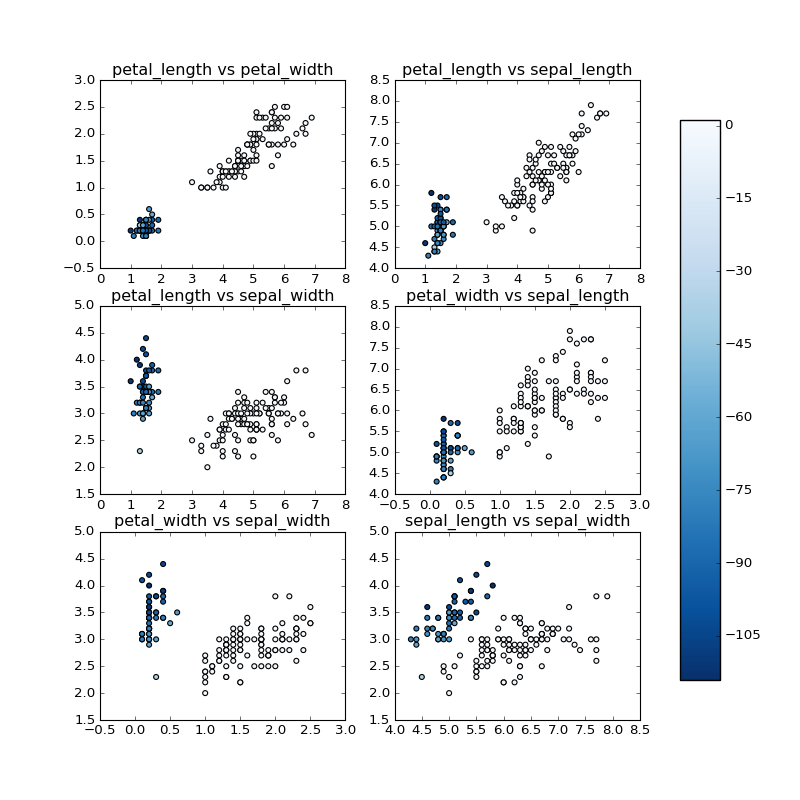

In [11]:
cmap = plt.cm.get_cmap('Blues_r')
fig = plt.figure(figsize=(10, 10))
k = 1
for i, v in enumerate(nodes):
    for j in range(i+1, len(nodes)):
        
        v_name = v.getName()
        v1_name = nodes[j].getName()
        ax = fig.add_subplot(3,2,k)
        ax.set_title("{} vs {}".format(v_name, v1_name))
        h = ax.scatter(x=iris[v_name].tolist(), y=iris[v1_name].tolist(), c=results['loglikelihood'].tolist(),
                        vmin=results.loglikelihood.min(), vmax=results.loglikelihood.max(), cmap=cmap
                        )
        k+=1

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(h, cax=cbar_ax)
    plt.show()